## 数据读取与划分

In [1]:
use_gpu = True
use_dataparallel = True

In [2]:
import os
import sys
sys.path.insert(0, '..')

import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

torch.manual_seed(42)

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96} 

选取 1993-2001年的数据作为训练集，剩下的作为测试集

In [3]:
train_year_list = np.arange(1993,2001,1)

images = []
label_df = []
for year in train_year_list:
    images.append(np.memmap(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20])))
    label_df.append(pd.read_feather(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
images = np.concatenate(images)
label_df = pd.concat(label_df)

print(images.shape)
print(label_df.shape)
plt.imshow(images[0], cmap='gray')
#设置输出格式为灰度颜色映
plt.show()

(793019, 64, 60)
(793019, 8)


构建DataSet

In [4]:
class MyDataset(Dataset):
    
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)
  
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]

划分测试集和验证集

In [5]:
train_val_ratio = 0.7
split_idx = int(images.shape[0] * 0.7)
train_dataset = MyDataset(images[:split_idx], (label_df.Ret_20d > 0).values[:split_idx])
val_dataset = MyDataset(images[split_idx:], (label_df.Ret_20d > 0).values[split_idx:])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, pin_memory=True)

## 模型搭建与可视化

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(46080, 2),
        )
        self.softmax = nn.Softmax(dim=1)
       
    def forward(self, x):
        x = x.reshape(-1,1,64,60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(-1,46080)
        x = self.fc1(x)
        x = self.softmax(x)
        return x


In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

In [8]:
device = 'cuda' if use_gpu else 'cpu'
net = Net().to(device)
net.apply(init_weights)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPoo

In [9]:
count = 0
for name, parameters in net.named_parameters():
    print(name, ':', parameters.size())
    count += parameters.numel()
print('total_parameters : {}'.format(count))

layer1.0.weight : torch.Size([64, 1, 5, 3])
layer1.0.bias : torch.Size([64])
layer1.1.weight : torch.Size([64])
layer1.1.bias : torch.Size([64])
layer2.0.weight : torch.Size([128, 64, 5, 3])
layer2.0.bias : torch.Size([128])
layer2.1.weight : torch.Size([128])
layer2.1.bias : torch.Size([128])
layer3.0.weight : torch.Size([256, 128, 5, 3])
layer3.0.bias : torch.Size([256])
layer3.1.weight : torch.Size([256])
layer3.1.bias : torch.Size([256])
fc1.1.weight : torch.Size([2, 46080])
fc1.1.bias : torch.Size([2])
total_parameters : 708866


In [10]:
import torch.onnx
x = torch.randn([1,1,64,60]).to(device)
torch.onnx.export(net,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "./cnn_baseline.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=False,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=False,  # whether to execute constant folding for optimization
                  input_names = ['input_images'],   # the model's input names
                  output_names = ['output_prob'], # the model's output names
                  dynamic_axes={'input_images' : {0 : 'batch_size'},    # variable length axes
                                 'output_prob' : {0 : 'batch_size'}})

## 模型训练与评估

In [11]:
def train_loop(dataloader, net, loss_fn, optimizer):
    
    running_loss = 0.0
    current = 0
    net.train()
    
    with tqdm(dataloader) as t:
        for batch, (X, y) in enumerate(t):
            X = X.to(device)
            y = y.to(device)
            y_pred = net(X)
            loss = loss_fn(y_pred, y.long())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
            current += len(X)
            t.set_postfix({'running_loss':running_loss})
    
    return running_loss

In [12]:
def val_loop(dataloader, net, loss_fn):

    running_loss = 0.0
    current = 0
    net.eval()
    
    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                loss = loss_fn(y_pred, y.long())

                running_loss += loss.item()
                running_loss = (len(X) * running_loss + loss.item() * current) / (len(X) + current)
                current += len(X)
            
    return running_loss

In [13]:
if use_gpu and use_dataparallel and 'DataParallel' not in str(type(net)):
    net = net.to(device)
    net = nn.DataParallel(net)

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)

start_epoch = 0
min_val_loss = 1e9
last_min_ind = -1
early_stopping_epoch = 5

from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()

In [15]:
start_time = datetime.datetime.now().strftime('%Y%m%d_%H-%M-%S')
os.makedirs(os.path.join("pt",start_time),)
epochs = 100
for t in range(start_epoch, epochs):
    print(f"Epoch {t}\n-------------------------------")
    time.sleep(0.2)
    train_loss = train_loop(train_dataloader, net, loss_fn, optimizer)
    val_loss = val_loop(val_dataloader, net, loss_fn)
    tb.add_histogram("train_loss", train_loss, t)
    torch.save(net, './pt'+os.sep+start_time+os.sep+'baseline_epoch_{}_train_{:5f}_val_{:5f}.pt'.format(t, train_loss, val_loss)) 
    if val_loss < min_val_loss:
        last_min_ind = t
        min_val_loss = val_loss
    elif t - last_min_ind >= early_stopping_epoch:
        break

print('Done!')
print('Best epoch: {}, val_loss: {}'.format(last_min_ind, min_val_loss))

Epoch 0
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:26<00:00, 34.89it/s]


Epoch 1
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:22<00:00, 40.62it/s]


Epoch 2
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:22<00:00, 40.56it/s]


Epoch 3
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:22<00:00, 40.66it/s]


Epoch 4
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:22<00:00, 40.54it/s]


Epoch 5
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:22<00:00, 40.71it/s]


Epoch 6
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:22<00:00, 40.56it/s]


Done!
Best epoch: 1, val_loss: 0.693060862993489


In [16]:
test_year_list = np.arange(2001,2020,1)

In [ ]:
images = []
label_df = []
for year in test_year_list:
    images.append(np.memmap(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20])))
    label_df.append(pd.read_feather(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
images = np.concatenate(images)
label_df = pd.concat(label_df)

In [18]:
dataset = MyDataset(images, (label_df.Ret_20d > 0).values)

In [19]:
test_dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)

In [21]:
net_path = './pt/20231115_15-51-08/baseline_epoch_1_train_0.717068_val_0.693061.pt'
device = 'cuda' if use_gpu else 'cpu'
net = torch.load(net_path)

In [22]:
def eval_loop(dataloader, net, loss_fn):
    
    running_loss = 0.0
    total_loss = 0.0
    current = 0
    net.eval()
    target = []
    predict = []
    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                target.append(y.detach())
                predict.append(y_pred.detach())
                loss = loss_fn(y_pred, y.long())
                
                running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
                current += len(X)
                t.set_postfix({'running_loss':running_loss})
            
    return total_loss, torch.cat(predict), torch.cat(target)

In [23]:
loss_fn = nn.CrossEntropyLoss()
test_loss, y_pred, y_target = eval_loop(test_dataloader, net, loss_fn)

predict_logit = (torch.nn.Softmax(dim=1)(y_pred)[:,1]).cpu().numpy()

100%|████████████████████████████████████████████████████████████| 686/686 [02:35<00:00,  4.42it/s, running_loss=0.696]


In [25]:
threshold = 0.

label_df['ret'] = (predict_logit>threshold) * label_df.Ret_20d
label_filtered = label_df[predict_logit>threshold]
ret_baseline = label_filtered .groupby(['Date'])['Ret_20d'].mean()

threshold = 0.58

label_df['ret'] = (predict_logit>threshold) * label_df.Ret_20d
label_filtered = label_df[predict_logit>threshold]
ret_cnn = label_filtered .groupby(['Date'])['Ret_20d'].mean()

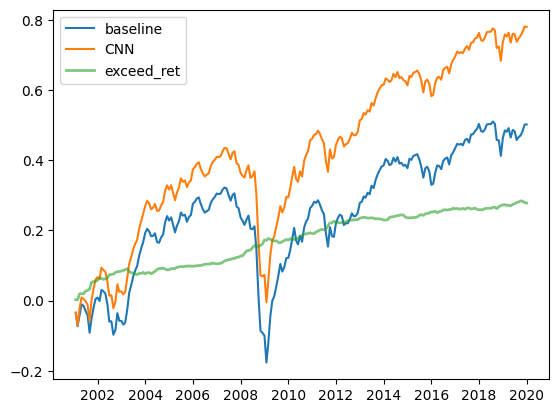

In [27]:
log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))
fig = plt.figure()
plt.plot(log_ret_baseline, label='baseline')
plt.plot(log_ret_cnn, label='CNN')
plt.plot(log_ret_cnn - log_ret_baseline, alpha=0.6, lw=2, label='exceed_ret')
plt.legend()
plt.show()
fig.savefig('performance1.png',dpi=300)